In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import rasterio

%load_ext autoreload
%autoreload 2
pd.options.mode.chained_assignment = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
## Kluge for now (shouldn't use sys append)
import sys
sys.path.append("/Users/dporter/Documents/Research/Projects/nasa_combined")

from nasa_combined.config import data_dir, data_path, cIce, cAir 

from nasa_combined.custom_funcs import *  # read_DICE_matfile, print_raster

print(data_path)

/Users/dporter/data/Antarctic/ROSETTA/radar


# Read in airborne data

In [4]:
suffix = '.csv'
datafile = 'rosetta_combined'

infile = os.path.join(data_path, 'for_COMBINED', datafile + suffix)
print(infile)

/Users/dporter/data/Antarctic/ROSETTA/radar/for_COMBINED/rosetta_combined.csv


## read in using Pandas and set `unixtime` as index

In [28]:
from nasa_combined.custom_funcs import read_ROSETTA_csv

df = read_ROSETTA_csv(infile)
df.columns

Index(['Line', 'X_EPSG_3031', 'Y_EPSG_3031', 'unixtime', 'thickness_dice',
       'rosetta_lidar', 'rosetta_lidar_wrtgeo', 'rosetta_lidar_thickness',
       'diff_diceltthick_rsaltthick', 'dice_thick_bedmapthick',
       'icebase_dice'],
      dtype='object')

## Extract single flight for development purposes

In [29]:
# print (df['Line'].unique())

# ln20 = df.where(df.Line == 'L20')

line = df.query('Line == "L780"')
# line.head()

In [27]:
import geopandas as gpd

fix_PROJ_path()

## Other outline options
# data/ASE_catchments_matchGL.geojson
# data/ASE_GroundingLine_simple.geojson

outlines = '../data/external/ASE_catchments+GL_3031.shp'

shapefile = gpd.read_file(outlines)

shapefile.head()

,groundedic,grounded_1,geometry
0,Grounded,GR,"POLYGON ((-1608074.997 -638549.999, -1608123.7..."
1,Grounded,GR,"POLYGON ((-1739481.254 -401608.850, -1740262.4..."
2,Grounded,GR,"POLYGON ((-1609325.000 -722675.000, -1609325.0..."
3,Grounded,GR,"MULTIPOLYGON (((-1604824.996 -612051.692, -160..."
4,Grounded,GR,"POLYGON ((-1908272.291 -410339.703, -1908540.1..."


# Reverse engineering TWTT 

In [30]:
PickTime = calc_twtt(line['thickness_dice'], cIce)

NameError: name 'calc_twtt' is not defined

### use sea level to calculate freeboard

Text(0, 0.5, 'Icesurface Diff [m]')

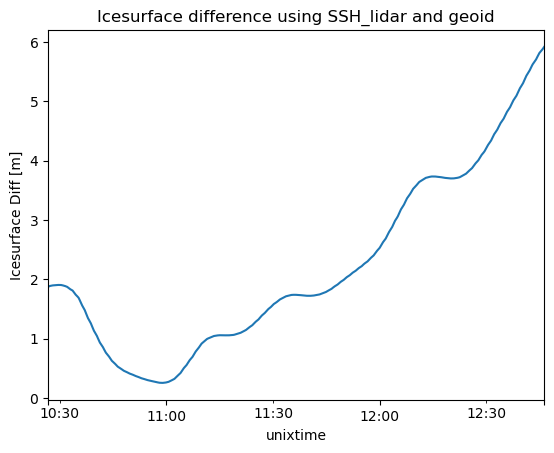

In [77]:
(line['rosetta_lidar_wrtssh'] - line['rosetta_lidar_wrtgeo']).plot()
plt.title('Icesurface difference using SSH_lidar and geoid')
plt.ylabel('Icesurface Diff [m]')

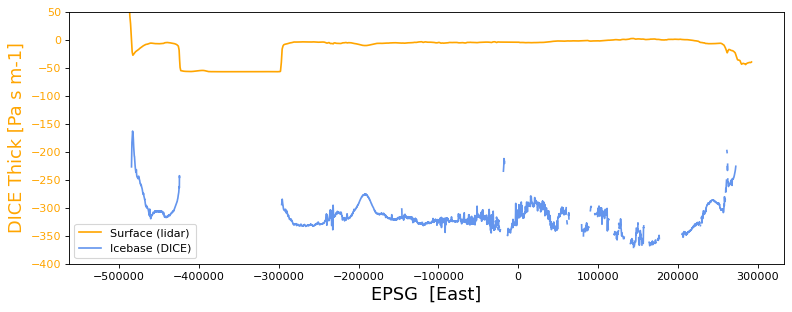

In [78]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=80)

ax.plot(line['X_EPSG_3031'], line['rosetta_lidar'], label='Surface (lidar)', color='orange')
ax.tick_params(axis='y', labelcolor='orange')
ax.set_ylabel('DICE Thick [Pa s m-1]', color='orange', fontsize=16)
ax.set_xlabel('EPSG  [East]', color='black', fontsize=16)
# add_basin_locs()

ax.plot(line['X_EPSG_3031'], line['icebase_dice'], color='cornflowerblue', 
        label='Icebase (DICE)', ls='-', marker='')
# ax.tick_params(axis='y', labelcolor='cornflowerblue')
# ax.set_ylabel('Icebase DICE', color='cornflowerblue', fontsize=16)


# ax4 = ax.twinx()
# ax4.plot(df['Dist'].loc[df['water'] >= 0.1]/1e3, df['water'].loc[df['water'] >= 0.1], color='green', ls='', marker='*')
# ax4.tick_params(axis='y', labelcolor='green')
# ax4.set_ylabel('Water', color='green', fontsize=16)
# ax4.spines['right'].set_position(('axes', 1.2))

plt.ylim([-400, 50])
# plt.xlim(pd.Timestamp('2015-12-02 11:10:00'), pd.Timestamp('2015-12-02 12:39:00'))
plt.legend()
plt.tight_layout()
# plt.savefig('figs/lineplot_UTG_sample_ClassBeta.png')

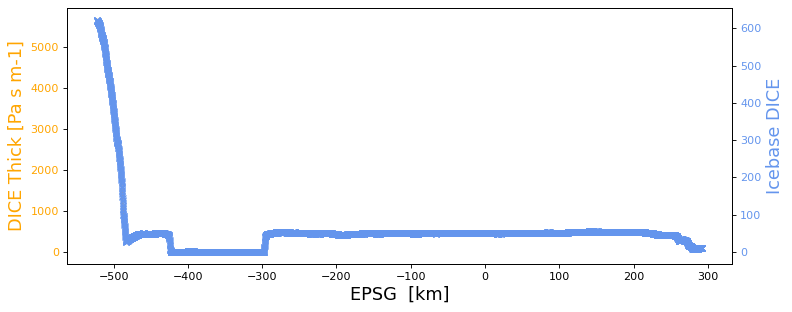

In [34]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=80)

ax.plot(line['X_EPSG_3031']/1e3, line['rosetta_lidar_thickness'], color='orange')
ax.tick_params(axis='y', labelcolor='orange')
ax.set_ylabel('DICE Thick [Pa s m-1]', color='orange', fontsize=16)
ax.set_xlabel('EPSG  [km]', color='black', fontsize=16)
# add_basin_locs()

ax3 = ax.twinx()
ax3.plot(line['X_EPSG_3031']/1e3, line['rosetta_lidar_wrtgeo'], color='cornflowerblue', ls='', marker='x')
ax3.tick_params(axis='y', labelcolor='cornflowerblue')
ax3.set_ylabel('Icebase DICE', color='cornflowerblue', fontsize=16)

# ax4 = ax.twinx()
# ax4.plot(df['Dist'].loc[df['water'] >= 0.1]/1e3, df['water'].loc[df['water'] >= 0.1], color='green', ls='', marker='*')
# ax4.tick_params(axis='y', labelcolor='green')
# ax4.set_ylabel('Water', color='green', fontsize=16)
# ax4.spines['right'].set_position(('axes', 1.2))


plt.tight_layout()
# plt.savefig('figs/lineplot_UTG_sample_ClassBeta.png')



## Impact of firn density assumptions on basal channel geometry

In [47]:
# line['bedmap2_surface_wrtell_SHIFT'] = line['bedmap2_surface_wrtell'].shift(0)
# print(line[['bedmap2_surface_wrtell_SHIFT', 'rosetta_lidar_wrtgeo']].corr())

# plt.matshow(line[['thickness_dice',
#        'rosetta_lidar', 'rosetta_lidar_wrtgeo', 'rosetta_lidar_thickness',
#        'diff_diceltthick_rsaltthick', 'dice_thick_bedmapthick']].corr())
# plt.show()

corr = line[['thickness_dice',
       'rosetta_lidar', 'rosetta_lidar_wrtgeo', 'rosetta_lidar_thickness',
       'diff_diceltthick_rsaltthick', 'dice_thick_bedmapthick']].corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

/var/folders/4b/tlrtp4_x48bdc8tdw206wqzr0000gn/T/ipykernel_51968/2774324597.py:12: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)


,thickness_dice,rosetta_lidar,rosetta_lidar_wrtgeo,rosetta_lidar_thickness,diff_diceltthick_rsaltthick,dice_thick_bedmapthick
thickness_dice,1.00,0.89,0.88,0.88,-0.28,-0.00
rosetta_lidar,0.89,1.00,1.00,1.00,-0.58,-0.23
rosetta_lidar_wrtgeo,0.88,1.00,1.00,1.00,-0.70,-0.40
rosetta_lidar_thickness,0.88,1.00,1.00,1.00,-0.70,-0.40
diff_diceltthick_rsaltthick,-0.28,-0.58,-0.70,-0.70,1.00,0.81
dice_thick_bedmapthick,-0.00,-0.23,-0.40,-0.40,0.81,1.00


### calculate mean density of ice column 
(from ROSETTA processing)

In [82]:
from nasa_combined.custom_funcs import calc_density_average

calc_density_average(line.thickness_dice)

0.8817862078155445

### calculate hydrostatic icebase using derived icebase 
(to compare with ROSETTA processing)

In [85]:
from nasa_combined.custom_funcs import calc_hydrostatic_thickness

df['icebase_hydro'] = calc_hydrostatic_thickness(line.rosetta_lidar_wrtgeo, rho_ave)

why `wrtgeo` though?

In [28]:
start_channel = '2015-12-02 11:20:00'
end_channel = '2015-12-02 11:25:00'

(-300000.0, 300000.0)

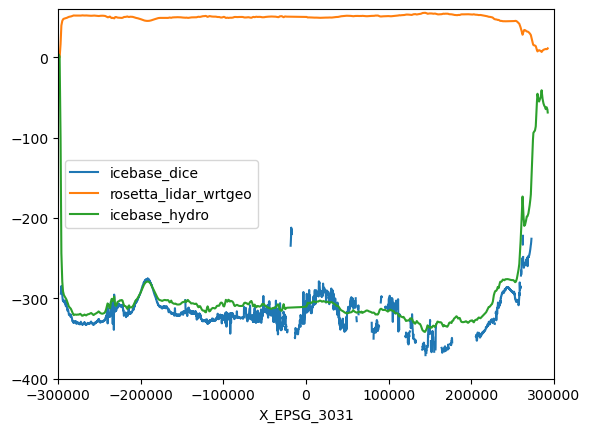

In [86]:
## plot
line.plot(x='X_EPSG_3031', y = ['icebase_dice', 'rosetta_lidar_wrtgeo', 'icebase_hydro'])
plt.ylim([-400, 60])
plt.xlim([-3e5, 3e5])
# plt.xlim(pd.Timestamp('2015-12-02 11:10:00'), pd.Timestamp('2015-12-02 12:39:00'))

##
# fig, ax = plt.subplots(figsize=(10, 4), dpi=80)

# ax.plot(line['X_EPSG_3031'], line['rosetta_lidar'], label='Surface (lidar)', color='orange')
# ax.tick_params(axis='y', labelcolor='orange')
# ax.set_ylabel('DICE Thick [Pa s m-1]', color='orange', fontsize=16)
# ax.set_xlabel('EPSG  [East]', color='black', fontsize=16)
# # add_basin_locs()

# ax.plot(line['X_EPSG_3031'], line['icebase_dice'], color='cornflowerblue', 
#         label='Icebase (DICE)', ls='-', marker='')
# # ax.tick_params(axis='y', labelcolor='cornflowerblue')
# # ax.set_ylabel('Icebase DICE', color='cornflowerblue', fontsize=16)

# # ax4 = ax.twinx()
# # ax4.plot(df['Dist'].loc[df['water'] >= 0.1]/1e3, df['water'].loc[df['water'] >= 0.1], color='green', ls='', marker='*')
# # ax4.tick_params(axis='y', labelcolor='green')
# # ax4.set_ylabel('Water', color='green', fontsize=16)
# # ax4.spines['right'].set_position(('axes', 1.2))

# plt.ylim([-400, 50])
# plt.xlim(pd.Timestamp(start_channel), pd.Timestamp(end_channel))
# plt.legend()
# plt.tight_layout()
# # plt.savefig('figs/lineplot_UTG_sample_ClassBeta.png')

# Read in REMA tile for this area
from 2015

In [51]:
# rema_file = '/Users/dporter/data/Antarctic/DEM/REMA/SETSM_WV01_20171016_102001006659B400_102001006CCF3100_seg1_2m_v1.0/SETSM_WV01_20171016_102001006659B400_102001006CCF3100_seg1_2m_v1.0_dem.tif'
rema_file = '/Users/dporter/data/Antarctic/DEM/REMA/SETSM_WV01_20151130_1020010048BBA700_1020010048C54400_seg1_2m_v1.0/SETSM_WV01_20151130_1020010048BBA700_1020010048C54400_seg1_2m_v1.0_dem.tif'
src = rasterio.open(rema_file)

In [52]:
print(src.name)
print(src.mode)
print(src.closed)
print('\n')
print_raster(src)

/Users/dporter/data/Antarctic/DEM/REMA/SETSM_WV01_20151130_1020010048BBA700_1020010048C54400_seg1_2m_v1.0/SETSM_WV01_20151130_1020010048BBA700_1020010048C54400_seg1_2m_v1.0_dem.tif
r
False


shape: (43397, 15820)
bounds: BoundingBox(left=-202416.0, bottom=-1268666.0, right=-170776.0, top=-1181872.0)
CRS: EPSG:3031



In [53]:
for i, dtype, nodataval in zip(src.indexes, src.dtypes, src.nodatavals):
    print(i, dtype, nodataval)

1 float32 -9999.0


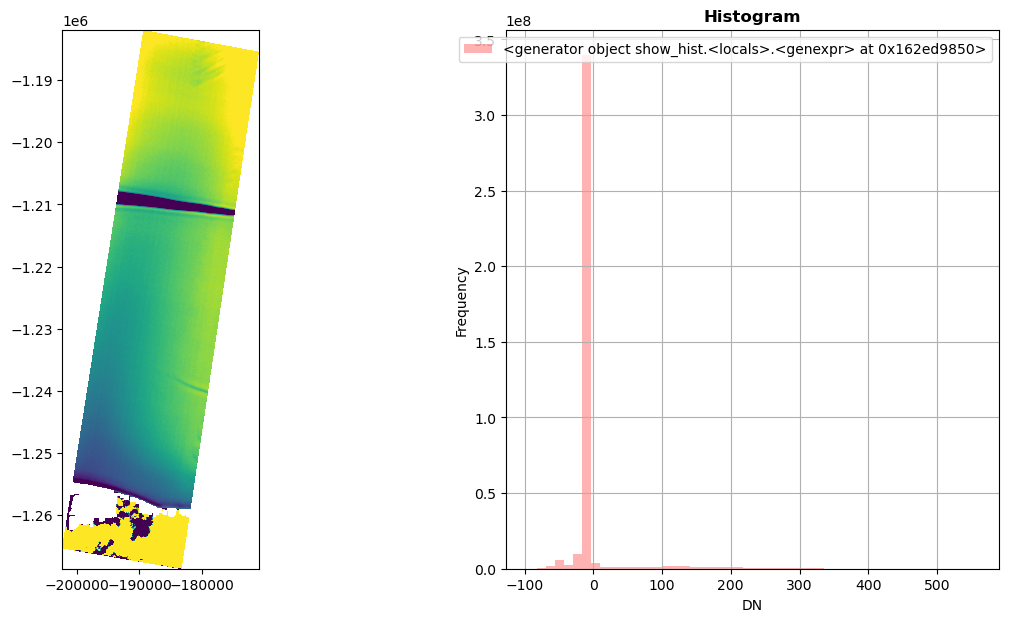

In [60]:
from rasterio.plot import show_hist

fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))

show(src, 
     interpolation='none', 
     vmin=-20, vmax=-5,
     transform=src.transform,
     ax=axrgb,
     )
show_hist(
    src, bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram",
    ax=axhist,
    )
plt.show()

### Convert dataframe to GeoDataFrame (geoPandas)

In [54]:
## 1
# import geopandas as gpd
# crs = {'init': 'epsg:3031'}
# gdf = gpd.GeoDataFrame(line, crs=crs).set_geometry('geometry')

## 1.2
# from shapely import wkt

# line['geometry'] = line['geometry'].apply(wkt.loads)
# gdf = gpd.GeoDataFrame(line, crs='epsg:4326')


## 2
gdf = gpd.GeoDataFrame(
    line, geometry=gpd.points_from_xy(line.X_EPSG_3031, line.Y_EPSG_3031)
)

In [58]:
gdf.head()

,Line,X_EPSG_3031,Y_EPSG_3031,unixtime,thickness_dice,rosetta_lidar,rosetta_lidar_wrtgeo,rosetta_lidar_thickness,diff_diceltthick_rsaltthick,dice_thick_bedmapthick,rosetta_lidar_wrtssh,icebase_dice,thickness_hydro,icebase_hydro,geometry
unixtime,,,,,,,,,,,,,,,
2015-12-02 10:26:43,L780,-522505.514637,-1.220915e+06,1.449052e+09,NaN,569.170911,623.730975,5674.295951,NaN,NaN,625.602283,NaN,4464.124857,-3840.393882,POINT (-522505.515 -1220915.492)
2015-12-02 10:26:44,L780,-522406.984790,-1.220898e+06,1.449052e+09,NaN,568.545575,623.104931,5668.600610,NaN,NaN,624.976947,NaN,4459.644175,-3836.539244,POINT (-522406.985 -1220897.678)
2015-12-02 10:26:45,L780,-522308.309493,-1.220880e+06,1.449052e+09,NaN,567.916847,622.475500,5662.874463,NaN,NaN,624.348219,NaN,4455.139258,-3832.663757,POINT (-522308.309 -1220880.072)
2015-12-02 10:26:46,L780,-522209.488288,-1.220863e+06,1.449052e+09,NaN,567.284704,621.842659,5657.117285,NaN,NaN,623.716076,NaN,4450.609927,-3828.767269,POINT (-522209.488 -1220862.654)
2015-12-02 10:26:47,L780,-522110.510614,-1.220845e+06,1.449052e+09,NaN,566.649147,621.206410,5651.329106,NaN,NaN,623.080519,NaN,4446.056208,-3824.849798,POINT (-522110.511 -1220845.429)


<AxesSubplot: >

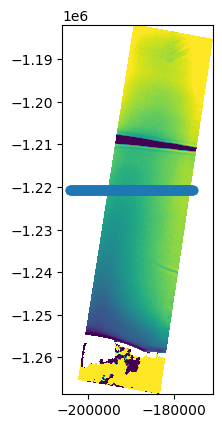

In [59]:
from rasterio.plot import show

## 1
# show(src, 
#      interpolation='none', 
#      vmin=-20, vmax=-5,
#      transform=src.transform,
#      )

## 2
fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax = rasterio.plot.show(src, extent=extent, ax=ax, 
                        interpolation='none', 
                        vmin=-20, vmax=-5, 
                        cmap='viridis',
                       )

gdf.loc[start_channel:end_channel].plot(ax=ax)



### Sample REMA under ROSETTA points

In [88]:
coord_list = [(x,y) for x,y in zip(gdf['geometry'].x , gdf['geometry'].y)]

In [89]:
coord_list[:5]

[(-522505.514637067, -1220915.4920904),
 (-522406.984789516, -1220897.67816384),
 (-522308.309492541, -1220880.07198186),
 (-522209.488287634, -1220862.65378756),
 (-522110.510614176, -1220845.42869854)]

In [90]:
gdf['rema'] = [x[0] for x in src.sample(coord_list)]
# print(gdf['rema'].head())

In [91]:
# gdf.replace(-9999, pd.NA, inplace=True)
gdf.loc[gdf['rema'] == -9999,'rema'] = np.nan

gdf.describe()


,X_EPSG_3031,Y_EPSG_3031,unixtime,thickness_dice,rosetta_lidar,rosetta_lidar_wrtgeo,rosetta_lidar_thickness,diff_diceltthick_rsaltthick,dice_thick_bedmapthick,rosetta_lidar_wrtssh,icebase_dice,thickness_hydro,icebase_hydro,rema
count,8371.000000,8.371000e+03,8.371000e+03,5379.000000,8371.000000,8371.000000,8371.000000,5379.000000,4957.000000,8371.000000,5379.000000,8371.000000,8371.000000,199.000000
mean,-109902.964065,-1.220620e+06,1.449056e+09,308.117909,2.872736,57.104613,519.500375,-138.332749,5.069685,59.304108,-313.245468,408.705249,-351.600635,-9.342135
std,236080.804601,2.200332e+01,2.416644e+03,29.081379,85.825162,85.752453,780.119658,19.430267,23.384209,85.825162,25.385170,613.741614,527.989161,1.393245
min,-522505.514637,-1.220915e+06,1.449052e+09,137.750468,-56.966527,-0.825691,-7.511595,-255.920300,-99.843622,-0.535155,-370.659204,-5.909579,-3840.393882,-11.191577
25%,-314264.317387,-1.220636e+06,1.449054e+09,299.034963,-7.978765,45.334095,412.419912,-146.249155,-8.295173,48.452607,-327.724410,324.462100,-317.605309,-10.691278
50%,-108258.987270,-1.220624e+06,1.449056e+09,312.391791,-4.673797,49.947681,454.391294,-140.927068,2.786439,51.757575,-317.090218,357.482142,-307.534461,-9.616969
75%,96375.775052,-1.220607e+06,1.449058e+09,324.157293,-1.878310,51.583321,469.271271,-134.025283,13.546981,54.553062,-304.513361,369.188630,-279.128004,-8.153692
max,292428.955095,-1.220559e+06,1.449060e+09,373.272514,569.170911,623.730975,5674.295951,23.190334,128.482081,625.602283,-162.807767,4464.124857,5.083888,-6.856775


### plot sampled REMA points vs ROSETTA
note different time period

(-12.0, -2.0)

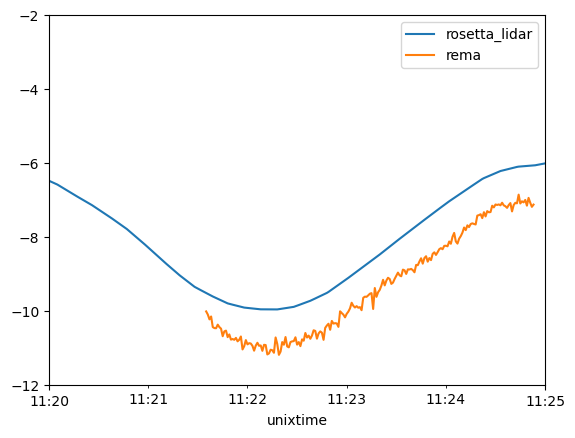

In [92]:
# gdf['rema'].plot()
gdf[['rosetta_lidar', 'rema']].plot()
plt.xlim(pd.Timestamp(start_channel), pd.Timestamp(end_channel))
plt.ylim([-12,-2])


### Appendix